In [170]:
import pandas as pd
import seaborn as sns

dc_wards = pd.read_csv('ACS_Housing_Characteristics_DC_Ward.csv')
dc_wards.columns

Index(['OBJECTID', 'STATEFP', 'SLDUST', 'GEOID', 'NAMELSAD', 'LSAD', 'LSY',
       'MTFCC', 'FUNCSTAT', 'ALAND',
       ...
       'DP04_0138E', 'DP04_0139E', 'DP04_0140E', 'DP04_0141E', 'DP04_0142E',
       'DP04_0143E', 'WARD', 'GIS_ID', 'SHAPEAREA', 'SHAPELEN'],
      dtype='object', length=161)

For this example, using the following columns in order to derive as predictors:
* number of housing units in ward - `DP04_0006E`
* number of housing units in ward in a 20 or more unit complex - `DP04_0013E`
* number of occupied units - `DP04_0057E`
* number of occupied units without an available vehicle - `DP04_0058E`

We will predict the percentage of renters spending more than 35% of their income on rent:
* number of occupants paying rent - `DP04_0126E`
* number of occupants whose rent exceeds 35% of income - `DP04_0142E`

In [171]:
dc_wards = dc_wards.loc[:,['NAMELSAD', 'DP04_0006E', 'DP04_0013E', 'DP04_0057E', 'DP04_0058E', 'DP04_0126E', 'DP04_0142E']]
dc_wards.set_index('NAMELSAD', inplace=True)
dc_wards.head(8)

,DP04_0006E,DP04_0013E,DP04_0057E,DP04_0058E,DP04_0126E,DP04_0142E
NAMELSAD,,,,,,
Ward 4,33459,7210,30675,6635,12149,4328
Ward 3,40665,21885,37623,8457,17140,5720
Ward 5,38521,6980,34896,10792,18187,7104
Ward 1,39068,20250,35796,16378,22359,6094
Ward 2,42701,29486,37598,18831,23227,7296
Ward 7,34727,2666,30877,11848,17897,7919
Ward 6,51191,22852,46264,15440,27794,7648
Ward 8,34844,3813,30657,13620,23212,12164


In [172]:
ward_pct = pd.concat([dc_wards.loc[:,'DP04_0013E'] / dc_wards.loc[:,'DP04_0006E'],
                     dc_wards.loc[:,'DP04_0058E'] / dc_wards.loc[:,'DP04_0057E'],
                     dc_wards.loc[:,'DP04_0142E'] / dc_wards.loc[:,'DP04_0126E']], axis='columns')\
                     .rename(columns={0:'Pct_20+Complex',
                                      1:'Pct_NoVehicle',
                                      2:'Pct_Rent35%orMore'})

In [173]:
ward_pct

,Pct_20+Complex,Pct_NoVehicle,Pct_Rent35%orMore
NAMELSAD,,,
Ward 4,0.215488,0.216300,0.356243
Ward 3,0.538178,0.224783,0.333722
Ward 5,0.181200,0.309262,0.390609
Ward 1,0.518327,0.457537,0.272552
Ward 2,0.690522,0.500851,0.314117
Ward 7,0.076770,0.383716,0.442476
Ward 6,0.446407,0.333737,0.275167
Ward 8,0.109431,0.444270,0.524039


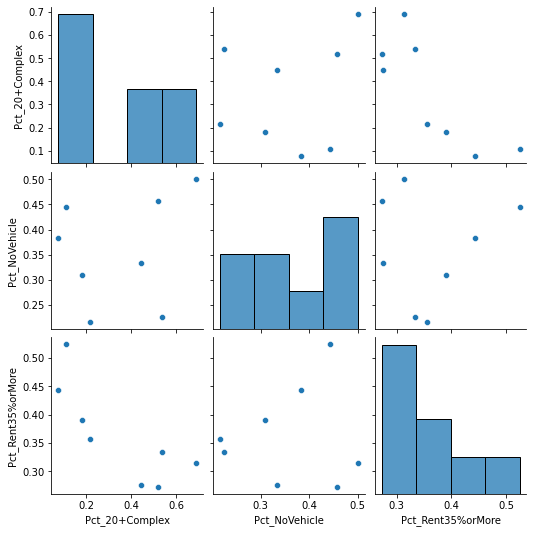

In [174]:
sns.pairplot(ward_pct)

Looks like percentage of housing units in a 20+ unit is a decent predictor for
percentage of renters spending 35% or more, so we will use that for now. In order
to best get across the point though, we may want to find the relevant summary 
ACS columns to get percentage of _renters_ w/o a car, in 20+ complex, etc, not 
just occupiers. 

### Example One - Supervised Learning

First step - in order to evaluate our model, we need to split the dataset into a 'train' and 'test' dataset. The training set will be used to optimize the model to make accurate predictions, but since they were used to create the model itself, they aren't particularly useful for determining whether the model is actually useful for anything. In order to do that, we need to show the model new observations that it hasn't seen yet - the 'test' set. 

In the real world, we would not be training a model on so few observations (8 observations are insufficient to make any sort of useful prediction) - but we will do so here for ease of understanding. 

In [175]:
import sklearn
from sklearn.model_selection import train_test_split

# all this function does is choose 25% of the data at random to be test data, and 75% to be training data
# functionally equivalent to just throwing all 8 observations in a bag and choosing 2 and 6, respectively
ward_train, ward_test = train_test_split(ward_pct, test_size=.25, train_size=.75, random_state=2600) #600

Training data:

In [176]:
ward_train

,Pct_20+Complex,Pct_NoVehicle,Pct_Rent35%orMore
NAMELSAD,,,
Ward 4,0.215488,0.216300,0.356243
Ward 7,0.076770,0.383716,0.442476
Ward 8,0.109431,0.444270,0.524039
Ward 5,0.181200,0.309262,0.390609
Ward 6,0.446407,0.333737,0.275167
Ward 2,0.690522,0.500851,0.314117


Test data:

In [177]:
ward_test

,Pct_20+Complex,Pct_NoVehicle,Pct_Rent35%orMore
NAMELSAD,,,
Ward 3,0.538178,0.224783,0.333722
Ward 1,0.518327,0.457537,0.272552


In [178]:
#now we train the linear regressor using the training data
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

ward_test.loc[:,'split'] = 'test'
ward_train.loc[:,'split'] = 'train'
ward_pct = pd.concat([ward_train, ward_test], axis = 'rows')

/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


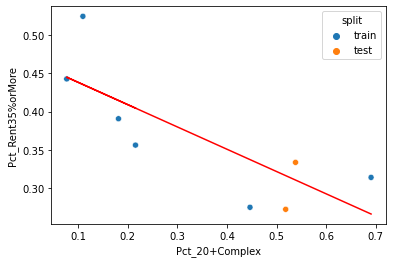

In [179]:
import matplotlib.pyplot as plt

lin_reg.fit(ward_train.loc[:,['Pct_20+Complex']], ward_train.loc[:,['Pct_Rent35%orMore']])

sns.scatterplot(x = 'Pct_20+Complex', y = 'Pct_Rent35%orMore', hue = 'split', data = ward_pct)
plt.plot(ward_train.loc[:,['Pct_20+Complex']], lin_reg.predict(ward_train.loc[:,['Pct_20+Complex']]), color='red')
plt.show()


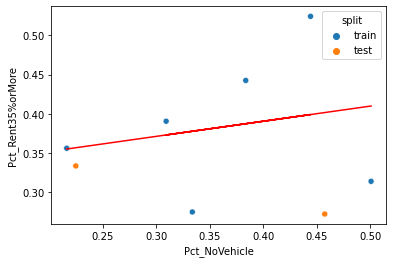

In [180]:
lin_reg.fit(ward_train.loc[:,['Pct_NoVehicle']], ward_train.loc[:,['Pct_Rent35%orMore']])
sns.scatterplot(x = 'Pct_NoVehicle', y = 'Pct_Rent35%orMore', hue = 'split', data = ward_pct)
plt.plot(ward_train.loc[:,['Pct_NoVehicle']], lin_reg.predict(ward_train.loc[:,['Pct_NoVehicle']]), color='red')
plt.show()

(_todo: add residual lines and generally make pretty for publication_)

### Example 2: Unsupervised Learning 

In [186]:
from sklearn import cluster
k_mean = cluster.KMeans(n_clusters = 2)
ward_pct.loc[:,'cluster'] = k_mean.fit_predict(ward_pct.loc[:,['Pct_NoVehicle','Pct_Rent35%orMore']])
ward_pct

,Pct_20+Complex,Pct_NoVehicle,Pct_Rent35%orMore,split,cluster
NAMELSAD,,,,,
Ward 4,0.215488,0.216300,0.356243,train,0
Ward 7,0.076770,0.383716,0.442476,train,1
Ward 8,0.109431,0.444270,0.524039,train,1
Ward 5,0.181200,0.309262,0.390609,train,0
Ward 6,0.446407,0.333737,0.275167,train,0
Ward 2,0.690522,0.500851,0.314117,train,1
Ward 3,0.538178,0.224783,0.333722,test,0
Ward 1,0.518327,0.457537,0.272552,test,1


<AxesSubplot:xlabel='Pct_20+Complex', ylabel='Pct_NoVehicle'>

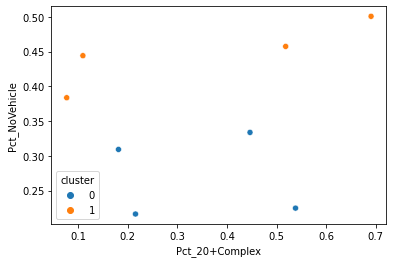

In [187]:
sns.scatterplot(x = 'Pct_20+Complex', y = 'Pct_NoVehicle', hue = 'cluster', data = ward_pct)